## Import Packages

In [1]:
import pandas as pd
import numpy as np
import os
import string
import re
import toolz as tz
import toolz.curried as c
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
%matplotlib inline

In [4]:
# ML packages
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
# Import Elastic Net, Ridge Regression, and Lasso Regression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier, export_graphviz

http://mlwiki.org/index.php/TF-IDF    tfidf site

## clean up original df dataset

In [5]:
df =pd.read_csv("./combined_recoded_data_deidentified.csv")
df = df.loc[:,:'retail_st_geo'] # subset only relevent data
df= df[(df.str_typ.notnull()) & (df.retail_name.notnull())] # only choose those who have store type
# merge tobacco/hookah/ane e-cig
df['str_typ'][df['str_typ'].isin(["(6) Tobacco shop",'(7) Hookah lounge','(8) E-cigarette/Vape shop'])] = "Tobacco Hookah ECig"

In [5]:
# change label
df.str_typ = df.str_typ.str.replace(r"\(.\) ", "")


### create a seperate store type for no tobacco. see if that's better for predicition

In [6]:
#df.str_typ[df.c_any_tob_sld == 0] = "No Tobacco"
df["str_typ1"] = df.str_typ.str.replace(" .*", "")

put every store_type in a dict: a list of all storenames

In [7]:
df.retail_name.notnull().sum()

16544

In [8]:
df.retail_name = df.retail_name.str.lower()
df.retail_name[df.retail_name.str.contains("eleven")] = "seveneleven"
df.retail_name = df.retail_name.str.replace(r"\#.*","")\
                 .str.replace('[-]','').str.replace('&*amp;', "").str.replace('\ & ', "").str.replace("\s*&\s*", ' and ')


/Users/JamesWang1/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [9]:
#df.loc[df.retail_name.str.contains(';')]

In [10]:
df[df['str_typ1'] == 'Tobacco']['c_any_tob_sld'] = 0 # why can't i change it

df.reset_index(inplace = True)

/Users/JamesWang1/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [11]:
# index column is unnecessary
df.drop('index', axis = 1, inplace = True)
df.head() 

,retail_name,retail_state,snap,wic,alcohol,pharmacy,any_tob_sld,str_typ,year,can_surveyD,storelistmatch,c_any_str_typ,c_any_tob_sld,retail_st_geo,str_typ1
0,1st avenue citgo,AL,0.0,0.0,1.0,0.0,1.0,Convenience store with or without gas,2016.0,1.0,1,1,1.0,Alabama,Convenience
1,1st avenue exxon,AL,1.0,1.0,1.0,0.0,1.0,Convenience store with or without gas,2016.0,1.0,1,1,1.0,Alabama,Convenience
2,40th street grocery,AL,1.0,0.0,1.0,0.0,1.0,Convenience store with or without gas,2016.0,1.0,1,1,1.0,Alabama,Convenience
3,6th ave exxon,AL,1.0,1.0,1.0,0.0,1.0,Convenience store with or without gas,2016.0,1.0,1,1,1.0,Alabama,Convenience
4,77th food mart,AL,0.0,0.0,1.0,0.0,1.0,Convenience store with or without gas,2016.0,1.0,1,1,1.0,Alabama,Convenience


In [12]:
# Need to be done later: 
# obviously more string cleaning is needed
# we need to convert all the major stores into the same name 

### some EDA, why current dataset is not useful in predicting c_any_tob_sob: too few 0s 

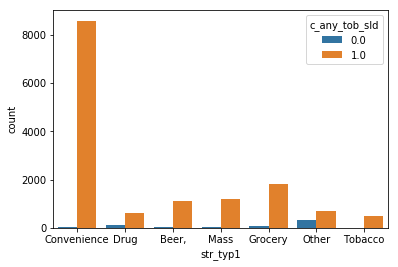

In [13]:
sns.countplot(x = 'str_typ1', hue = 'c_any_tob_sld', data= df )

In [14]:
df['str_typ1'].value_counts()/df.shape[0] * 100

Convenience    55.887331
Grocery        12.149420
Beer,           7.984768
Other           7.888056
Mass            7.785300
Drug            4.902079
Tobacco         3.403046
Name: str_typ1, dtype: float64

In [15]:
a = df.groupby('str_typ1')['c_any_tob_sld'].agg({'pct': 'mean'})
# if assuming this ground truthing sample is representative
a[a['pct']>.95] # those stores are almost always tobacco sellers, especially convenience store

/Users/JamesWang1/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


,pct
str_typ1,
"Beer,",0.958478
Convenience,0.996286
Grocery,0.963733
Mass,0.966503
Tobacco,0.973948


## put bag of words into dictionary, key = store type

need tfidf, but can't just collapse all the words together. otherwise two store names may get mooshed and confuse the classification

### what's to be done? 
under column drug store, "rite aid" contains "rite", "aid", "rite aid", so add the 3 scores to it



preprocessing using packages
https://stackoverflow.com/questions/48865150/pipeline-for-text-cleaning-processing-in-python

## TFIDF

In [16]:
# or this way
# https://stackoverflow.com/questions/26195699/sklearn-how-to-speed-up-a-vectorizer-eg-tfidfvectorizer
import Stemmer
from sklearn.feature_extraction.text import TfidfVectorizer
english_stemmer = Stemmer.Stemmer('en') # stem words
class StemmedTfidfVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(TfidfVectorizer, self).build_analyzer()
        return lambda doc: english_stemmer.stemWords(analyzer(doc))


### make ngrams manually?

In [17]:
tfidf_n = TfidfVectorizer(min_df=1, stop_words=None, analyzer='word',
                               ngram_range=(1,3), sublinear_tf= False, token_pattern= '(?u)\S\S+')
# next: write a function for each str_type and its belonged retail_names.
from itertools import chain
def tokenize1(str_type):
        b = list(map(lambda x: tfidf_n.build_analyzer()(x), df.retail_name[df.str_typ== str_type])) 

        return list(chain(*b))
dict1 = {}
colNames = list(df.str_typ.unique())

for i in colNames:
    dict1[i] = "!!!".join(tokenize1(i)) # join by 3 !, most likely not appear in store name


### Make TFIDF

In [18]:
# parameters for NB: stop_word = None cuz not sentence, sublinear_tf= True to not count 2 occurance as merely 2 since it's 
# not as fair. token_pattern: only seperate by comma (remove space), not remove punctuation like 'Wal-mart' 
tfidf = StemmedTfidfVectorizer(min_df=1, stop_words=None, analyzer='word',
                               ngram_range=(1,1), sublinear_tf= True, token_pattern= '[^!!!]+'
)
# get tfidf dictionary
tfidf1 = tfidf.fit_transform(dict1.values())
# still have the issue for label loss

Convert that to DF

In [19]:
tfidf

StemmedTfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
            dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
            lowercase=True, max_df=1.0, max_features=None, min_df=1,
            ngram_range=(1, 1), norm='l2', preprocessor=None,
            smooth_idf=True, stop_words=None, strip_accents=None,
            sublinear_tf=True, token_pattern='[^!!!]+', tokenizer=None,
            use_idf=True, vocabulary=None)

Convert back to dataframe and put colname/rowname

In [20]:
tfidf_df = pd.DataFrame(tfidf1.T.todense())
tfidf_df.columns = list(dict1.keys())
# some how can't reset index
tfidf_df["token"] = tfidf.get_feature_names()
tfidf_df.set_index('token', inplace=True)
str_typ_names =list(dict1.keys()) # turn dict() back to list()
#tfidf_df.sort_values(by =str_typ_names[4] ,ascending= False)[:30] # not the best tokenizer, still need a way to seperate out different store names

In [21]:
colNames = tfidf_df.columns 
# get top 500 tokens (index) of each str_typ
tfidf_df.sort_values(by = colNames[4],ascending= False).index[:50]
# grocery store has beer and wine in names? 

Index(['dixie stor', 'winn dixie stor', 'food lion', 'publix sup',
       'publix super market', 'marsh supermarkets llc', 'supermarkets llc',
       'marsh', 'marsh supermarket', 'super markets inc', 'hannaford', 'lion',
       'super one food', 'marketplace food', 'publix', 'iga',
       'shaw's beer win', 'shaw's beer', 'supermarket', 'save lot',
       'hometown food', 'markets inc', 'giant eagl', 'super on', 'giant',
       'shaw', 'kroger', 'quillin', 'bravo', 'winndixie stor',
       'bravo supermarket', 'super market', 'fareway', 'lion stor',
       'food lion stor', 'one food', 'groceri', 'meat', 'carlie c', 'maynard',
       'carli', 'zup', 'hyve', 'food', 'cub food', 'family food', 'hitchcock',
       'fiesta food', 'food drug', 'hannaford supermarket'],
      dtype='object', name='token')

In [22]:
tfidf_df.shape

(25640, 7)

In [24]:
a = pd.Series(tfidf_df.index.values)
a[a.str.contains("prap")]

18113    prapti,inc.
dtype: object

Problem: tfidf_df doesn't contain 'smokehous'. but rname_tokens has that token. Apparently the stemming function wasn't consistent? 

Weird. why is tfidf seperate by the comma, when it is not told to 

## use build analyzer to tokenize each store! 

In [25]:
tfidf_stem_each = StemmedTfidfVectorizer(min_df=1, stop_words=None, analyzer='word',
                               ngram_range=(1,3), sublinear_tf= True, token_pattern= '(?u)\S\S+'
)

In [26]:
rname_tokens = list(map(lambda x: tfidf_stem_each.build_analyzer()(x), df.retail_name)) 
rname_tokens[1:10]

[['1st', 'avenu', 'exxon', '1st avenu', 'avenue exxon', '1st avenue exxon'],
 ['40th',
  'street',
  'groceri',
  '40th street',
  'street groceri',
  '40th street groceri'],
 ['6th', 'ave', 'exxon', '6th ave', 'ave exxon', '6th ave exxon'],
 ['77th', 'food', 'mart', '77th food', 'food mart', '77th food mart'],
 ['78', 'food', 'mart', '78 food', 'food mart', '78 food mart'],
 ['airport', 'mini', 'mart', 'airport mini', 'mini mart', 'airport mini mart'],
 ['amoco', 'bp', 'amoco bp'],
 ['bankhead',
  'food',
  'mart',
  'bankhead food',
  'food mart',
  'bankhead food mart'],
 ['bmm', 'foodmart', 'bmm foodmart']]

### winn dixie probe for tfidf token

In [27]:
winn_dixie_tfidf = tfidf_df.loc[['winn','dixi', 'winn dixi']]
tfidf_df.loc[['winn','dixi', 'winn dixi']]

,Convenience store with or without gas,Drug store or pharmacy,"Beer, wine, liquor store",Mass merchandiser,Grocery store,Other store type not listed,Tobacco Hookah ECig
token,,,,,,,
winn,0.003343,0.0,0.016446,0.029548,0.038066,0.000000,0.011496
dixi,0.009719,0.0,0.014477,0.026010,0.033657,0.006191,0.010120
winn dixi,0.003343,0.0,0.016446,0.029548,0.038066,0.000000,0.011496


In [28]:
tfidf_df.loc[['harri','teeter', 'harris teet']]

,Convenience store with or without gas,Drug store or pharmacy,"Beer, wine, liquor store",Mass merchandiser,Grocery store,Other store type not listed,Tobacco Hookah ECig
token,,,,,,,
harri,0.006462,0.0,0.015147,0.0,0.020926,0.008029,0.0
teeter,0.000000,0.0,0.000000,0.0,0.031065,0.000000,0.0
harris teet,0.000000,0.0,0.000000,0.0,0.031065,0.000000,0.0


In [29]:
winn_df = tfidf_df.loc[tfidf_df.index.str.contains(r'winn')]
dixie_df = tfidf_df.loc[tfidf_df.index.str.contains(r'dixi')]
winn_df.append(dixie_df).to_csv('winn_dixie_tfidf.csv')


### avg up tfidf scores for all tokens of all 16544 store_names, for each str_typ as column
 for example:
'rite aid' for str_typ = Grocery 
rite = .5, aid = .6,  GroceryScore = mean(.5+.6) = .55


In [30]:
df_score_mean = pd.DataFrame(list(map(lambda x: tfidf_df.loc[x,:].mean(0), rname_tokens)))
#df_score_mean.rename(columns= lambda x: 'mean:'+ x, inplace = True)

df_score_max = pd.DataFrame(list(map(lambda x: tfidf_df.loc[x,:].max(0), rname_tokens)))
df_score_max.rename(columns= lambda x: 'max:'+ x, inplace = True)

df_score_median = pd.DataFrame(list(map(lambda x: tfidf_df.loc[x,:].median(0), rname_tokens)))
df_score_median.rename(columns= lambda x: 'median:'+ x, inplace = True)

In [89]:
#df_score = df_score_mean.join(df_score_max).join(df_score_median)

### sanity check for if mismatch happens, already fixed

build a key-value dict to see where mismatch starts

for ct, value in enumerate(d10.items()):
    if (ct>=860) and (ct<870) :
        print(value)

In [31]:
df_join = df.join(df_score_mean)

##Sanity Check

In [32]:

colNames[2]

'Beer, wine, liquor store'

In [33]:
# now looks right
df_join.sort_values(by =  colNames[-1],ascending= False)[:5]

,retail_name,retail_state,snap,wic,alcohol,pharmacy,any_tob_sld,str_typ,year,can_surveyD,...,c_any_tob_sld,retail_st_geo,str_typ1,Convenience store with or without gas,Drug store or pharmacy,"Beer, wine, liquor store",Mass merchandiser,Grocery store,Other store type not listed,Tobacco Hookah ECig
15422,avail vapor,VA,0.0,0.0,0.0,0.0,1.0,Tobacco Hookah ECig,2016.0,1.0,...,1.0,Virginia,Tobacco,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.068184
15423,avail vapor,VA,0.0,0.0,0.0,0.0,1.0,Tobacco Hookah ECig,2016.0,1.0,...,1.0,Virginia,Tobacco,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.068184
15756,avail vapor,VA,0.0,0.0,0.0,0.0,1.0,Tobacco Hookah ECig,2016.0,1.0,...,1.0,Virginia,Tobacco,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.068184
5650,low bob's,IN,0.0,0.0,0.0,0.0,1.0,Tobacco Hookah ECig,2016.0,1.0,...,1.0,Indiana,Tobacco,0.008227,0.0,0.0,0.0,0.004526,0.005616,0.067243
5809,low bob,IN,0.0,0.0,0.0,0.0,1.0,Tobacco Hookah ECig,2016.0,1.0,...,1.0,Indiana,Tobacco,0.008227,0.0,0.0,0.0,0.004526,0.005616,0.067243


In [34]:
df_join.to_csv("df_score_predict_no_cat.csv")

# Use sklearn to build pipeline for classification

multiclass https://github.com/knathanieltucker/bit-of-data-science-and-scikit-learn/blob/master/notebooks/Multiclass.ipynb

try only NC

In [94]:
df.c_any_tob_sld.value_counts()/df.shape[0] # can't predict anytobacco sold cuz it's 4% not tobacco sold, too small

1.0    0.877841
0.0    0.038322
Name: c_any_tob_sld, dtype: float64

Make X, y

In [95]:
Xy = df_join.loc[:,'Convenience store with or without gas':]
Xy = df_join.loc[:,['str_typ','c_any_tob_sld']].join(Xy)
Xy.dropna(axis = 0, how = 'any', inplace = True)
X = Xy.loc[:,'Convenience store with or without gas':]
y = Xy.str_typ
#y = Xy.c_any_tob_sld

In [96]:
X.columns

Index(['Convenience store with or without gas', 'Drug store or pharmacy ',
       'Beer, wine, liquor store', 'Mass merchandiser', 'Grocery store ',
       'Other store type not listed', 'Tobacco Hookah ECig', 'No Tobacco'],
      dtype='object')

need do deal with Null score later

Train test split, test_size = .5 actually performed much better than .3

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .5, random_state = 2)

### build pipeline for many models at once

In [98]:
# Pipeline dictionary
pipelines = {"l1": make_pipeline(StandardScaler(), LogisticRegression(penalty="l1",random_state=123)),
            "l2": make_pipeline(StandardScaler(), LogisticRegression(penalty="l2",random_state=123)),
            "rf" : make_pipeline(StandardScaler(), RandomForestClassifier(random_state=123)),
            "gb" :make_pipeline(StandardScaler(), GradientBoostingClassifier(random_state=123)),
             'oneVone': make_pipeline(StandardScaler(), OneVsOneClassifier(RandomForestClassifier(random_state=123))),
            'dt' : make_pipeline(DecisionTreeClassifier(random_state=123))
                                 }

In [99]:
#pipelines['dt'].get_params()

In [100]:
# Logistic Regression hyperparameters
l1_HP = {"logisticregression__C": np.linspace(1e-3,1e3, 10)}
l2_HP = {"logisticregression__C" : np.linspace(1e-3,1e3, 10)}
rf_HP = {"randomforestclassifier__n_estimators" : [100,200],
        "randomforestclassifier__max_features" : ["auto", "sqrt", .33]}
# Boosted Tree hyperparameters
gb_HP = {"gradientboostingclassifier__learning_rate": [.05,.1,.2],
        "gradientboostingclassifier__n_estimators": [100,200],
        "gradientboostingclassifier__max_depth":[1,3,5]}
oneVone_HP = {'onevsoneclassifier__estimator__n_estimators': [10,5]}
dt_HP = { 'decisiontreeclassifier__max_depth': [None, 3,5]}

In [101]:
# Create hyperparameters dictionary
HP = {
    "gb" :gb_HP,
    "rf":rf_HP,
    "l1":l1_HP,
    "l2":l2_HP,
    'oneVone': oneVone_HP,
    'dt' : dt_HP
}

In [104]:
# check
for key in HP.keys():
    if key in pipelines.keys():
         print("good")
    else:
        print("not good")

good
good
good
good
good
good


# Create empty dictionary called fitted_models
fitted_models = {}
    # Loop through model pipelines, tuning each one and saving it to fitted_models
for name, pipeline in pipelines.items():
    # Create cross-validation object from pipeline and hyperparameters
    model = GridSearchCV(pipeline, HP[name], cv = 5, n_jobs=-1)
    
    # Fit model on X_train, y_train
    model.fit(X_train, y_train)
    
    # Store model in fitted_models[name] 
    fitted_models[name] = model
    
    # Print '{name} has been fitted'
    print(name, ' has been fitted')

In [108]:
### Create empty dictionary called fitted_models
fitted_models = {}
    # Loop through model pipelines, tuning each one and saving it to fitted_models
for name, pipeline in pipelines.items():
    if name in ['l1']: # only fit models  I want to fit
    # Create cross-validation object from pipeline and hyperparameters
        model = GridSearchCV(pipeline, HP[name], cv = 2, n_jobs=-1)
        
        # Fit model on X_train, y_train
        model.fit(X_train, y_train)
        
        # Store model in fitted_models[name] 
        fitted_models[name] = model
        
        # Print '{name} has been fitted'
        print(name, ' has been fitted')
### gb is significantly slower

Process ForkPoolWorker-78:
Process ForkPoolWorker-79:
Process ForkPoolWorker-77:
Process ForkPoolWorker-75:
Process ForkPoolWorker-76:
Process ForkPoolWorker-74:
Process ForkPoolWorker-73:
Process ForkPoolWorker-80:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/JamesWang1/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/JamesWang1/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/JamesWang1/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/JamesWang1/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/JamesWang1/anacon

KeyboardInterrupt: 

In [ ]:
# Display best_score_ for each fitted model
for name, model in fitted_models.items():
    print(name, model.best_score_)
    
# base: .88 (DT),  change ngram .925, change to max: .825, change to median: .914 (mean is the best among the 3 )
# all 3: .911, all + stringclean: .935 , back to only mean: .929 : very similar, clean string ; (l1): .930

### confusion matrix and true positive rate 

In [ ]:
def cm_to_df(cm, label):
    """make labels=colNames for confusion matrix"""
    cf1 = pd.DataFrame(cm)
    cf1.columns = label
    cf1["index"] = label
    cf1.set_index('index', inplace=True)
    return cf1

In [ ]:
# Code here
X_test = X_test.iloc[:,:8]
conf = {}
from sklearn.metrics import roc_curve, auc, confusion_matrix
for name, model in fitted_models.items():
    #pred = model.predict_proba(X_test)[:,1]
    #fpr, tpr, threshold = roc_curve(y_test, pred)
    #print(name, auc(fpr,tpr))
    pred2 = model.predict(X_test)
    colNames = y_test.unique() # don't know if this works
    cm = confusion_matrix(y_test, pred2, labels = colNames, sample_weight = None)
    conf[name] = cm_to_df(cm, colNames) # make label
    #conf[name] = cm
    tp = np.diag(conf[name]).sum()/len(y_test)
    print(name, "true rate: ", tp)
    print()
    #print(confusion_matrix(y_test, pred2, labels = None, sample_weight = None))
    


result shows all models are really similar. I don't think model selection matters too much at this situation. It's more about preprocessing of TFIDF

In [ ]:
#conf['dt'].to_csv("confuMatDT.csv")

In [ ]:
conf['l1']

In [ ]:
conf['l1'].to_csv("confuMatl1.csv")

Save Model

In [ ]:
fitted_models["rf"].best_estimator_

In [ ]:
import pickle
with open("tobacco_model_gb.pkl", "wb") as f:
    pickle.dump(fitted_models['gb'].best_estimator_,f)

In [ ]:
import pickle
with open("tobacco_model_DT.pkl", "wb") as f:
    pickle.dump(fitted_models['dt'].best_estimator_,f)

In [ ]:
import pickle
with open("tobacco_model_l1_best.pkl", "wb") as f:
    pickle.dump(fitted_models['l1'].best_estimator_,f)

## evaluate model and see what did we predict wrong

import pickle
with open("tobacco_model_gb.pkl", "rb") as f:
    model = pickle.load(f)

In [109]:
# import DT
import pickle
with open("tobacco_model_l1_best.pkl", "rb") as f:
    model = pickle.load(f)

In [110]:
from sklearn.metrics import roc_curve, auc, confusion_matrix
def predictModel(model): 
    pred = model.predict(X_test)
    label = y_test.unique()
    cm = confusion_matrix(y_test, pred, labels = label, sample_weight = None)
    cm = cm_to_df(cm, label) # make label
    #conf[name] = cm
    tp = np.diag(cm).sum()/len(y_test)
    print(tp)
    return(cm, pred)

In [111]:
X_test.head()

,Convenience store with or without gas,Drug store or pharmacy,"Beer, wine, liquor store",Mass merchandiser,Grocery store,Other store type not listed,Tobacco Hookah ECig,No Tobacco
7028,0.023003,0.008418,0.013818,0.000000,0.008317,0.012904,0.003608,0.003287
4615,0.009870,0.005989,0.007500,0.012388,0.025039,0.008434,0.006052,0.016041
6493,0.019563,0.026535,0.005245,0.119466,0.029979,0.028323,0.007975,0.038691
4518,0.032460,0.005989,0.005550,0.011579,0.004647,0.005380,0.004882,0.004448
13812,0.014291,0.000000,0.010689,0.000000,0.002827,0.006870,0.000000,0.014124


In [116]:
#cm, pred2 = predictModel(model) # prediction increased by 5% after I change traintestsplit = .5

In [113]:
#cm, pred2 = predictModel(fitted_models['l1']) # prediction increased by 5% after I change traintestsplit = .5

KeyError: 'l1'

In [ ]:
cm # label is wrong and misplaced. need to fix it

In [ ]:
dict1.keys()

In [ ]:
# write out conf matrix and visualize it in excel

94% accuracy in predicting store types

### make confu matrix for walmart only

In [ ]:
# first join the test and pred
X_test1 = X_test
X_test1['true'] = y_test
X_test1['pred'] = pred2
df_result = pd.DataFrame(df_join.retail_name).join(X_test1, how = 'inner')

In [ ]:
# check: join method is correct
(df_result.true ==df_result.pred).mean()

In [ ]:
df_walmart = df_result.loc[df_result.retail_name.str.contains("walmart")]

In [ ]:
df_walmart.retail_name.unique() # they all seems to be mass merch

In [ ]:
# which walmart is predicted and coded as Mass 
df_walmart['Mass_true'] = df_walmart.true.str.contains("Mass")
df_walmart['Mass_pred'] = df_walmart.pred.str.contains("Mass")

In [ ]:
label_wal = df_walmart.Mass_true.unique()
cm_wal = confusion_matrix(df_walmart.Mass_true, df_walmart.Mass_pred, labels= label_wal)
cm_wal1 = cm_to_df(cm_wal, label_wal)
cm_wal1

In [ ]:
# true positive(sensitivty):
tp, fn, fp, tn  = cm_wal.ravel()


In [ ]:
tpr, fpr = np.diag(cm_wal)/cm_wal.sum(1)
print(tpr,fpr)
# high tpr and low fpr: it's better to err on the yes side (predict more walmarts as mass merchandizer than not). Good
# it shows machine can help to reduce  human coding error by predicting more walmart as right (Mass Merch)

By definition a confusion matrix :math:`C` is such that :math:`C_{i, j}`
is equal to the number of observations known to be in group :math:`i` but
predicted to be in group :math:`j`.

Thus in binary classification, the count of true negatives is
:math:`C_{0,0}`, false negatives is :math:`C_{1,0}`, true positives is
:math:`C_{1,1}` and false positives is :math:`C_{0,1}`.

### get only the wrong predictions

In [117]:

idx = (pred2 !=y_test).index 
idx = idx[pred2 !=y_test]
df_error = df_join.iloc[idx] 
df_pred = pd.DataFrame({'pred':pred2[(pred2 !=y_test)]}, index= idx)
df_error = df_error.join(df_pred)

In [118]:
df_error.head()

,retail_name,retail_state,snap,wic,alcohol,pharmacy,any_tob_sld,str_typ,year,can_surveyD,...,str_typ1,Convenience store with or without gas,Drug store or pharmacy,"Beer, wine, liquor store",Mass merchandiser,Grocery store,Other store type not listed,Tobacco Hookah ECig,No Tobacco,pred
8667,the farr side,IA,0.0,0.0,1.0,0.0,1.0,Drug store or pharmacy,2016.0,1.0,...,Drug,0.004248,0.037198,0.008019,0.002219,0.005043,0.004955,0.008050,0.005642,Convenience store with or without gas
3047,family dollar store 9414,FL,1.0,0.0,1.0,0.0,1.0,Grocery store,2016.0,1.0,...,Grocery,0.009051,0.021385,0.004888,0.064805,0.021680,0.014347,0.010912,0.019218,Mass merchandiser
2186,walgreens,FL,1.0,1.0,1.0,1.0,1.0,Grocery store,2015.0,1.0,...,Grocery,0.010556,0.162385,0.012636,0.051295,0.015952,0.000000,0.000000,0.009861,Drug store or pharmacy
8457,kwik stop liquor,IA,1.0,0.0,1.0,0.0,1.0,"Beer, wine, liquor store",2016.0,1.0,...,"Beer,",0.011968,0.009876,0.025627,0.002480,0.008884,0.015300,0.007228,0.007180,Convenience store with or without gas
12107,store,ND,1.0,0.0,0.0,0.0,1.0,Convenience store with or without gas,2016.0,1.0,...,Convenience,0.020618,0.080238,0.031471,0.096940,0.035151,0.030503,0.031481,0.036336,Mass merchandiser


In [119]:
# very annoy way of subsetting the data
df_error2 = pd.DataFrame(df_error.iloc[:,0:2]).join(df_error.iloc[:,-10:]).drop_duplicates()

In [120]:
df_error2.to_csv('df_error4.csv')

Why does error exist? Bad data coding

In [121]:
#df_error2.loc[df_error2.retail_name.str.contains(r"wal-*mart")]

coding of wal-mart storetype wasn't consistent. It could be beer, grocery, convenience, mass, or other. The bad data quality confuses people

In [122]:
df.loc[df.retail_name.str.contains('beer') & df.str_typ.str.contains('Groc')].retail_name.unique()
# bad naming. Shaw's is a grocery store in VT, not named as beer &amp and wine

array(["shaw's beer  wine", "shaw's beer  wine ", "shaw's beerwine",
       'shaws beer and wine'], dtype=object)

In [123]:
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

## Visualize DT

In [146]:
def visualize_tree(tree, feature_names):
    """Create tree png using graphviz.

    Args
    ----
    tree -- scikit-learn DecsisionTree.
    feature_names -- list of feature names.
    """
    with open("dt.dot", 'w') as f:
        export_graphviz(tree, out_file=f,
                        feature_names=feature_names, max_depth = 3)

    command = ["dot", "-Tpng", "dt.dot", "-o", "dt.png"]
    try:
        subprocess.check_call(command)
    except:
        exit("Could not run dot, ie graphviz, to "
             "produce visualization")

In [125]:
fitted_models['dt'].fit(X_train, y_train)
fitted_models['dt'].best_estimator_

KeyError: 'dt'

In [ ]:
with open("tobacco_model_DT.pkl", "wb") as f:
    pickle.dump(fitted_models['dt'].best_estimator_,f)

In [ ]:

with open("tobacco_model_DT.pkl", "rb") as f:
    model = pickle.load(f)

### the model we fitted can't be visualized. have to make new model. make a much simplier DT for visual example purpose. 

In [126]:
dt = DecisionTreeClassifier(max_depth= 10, max_leaf_nodes=10)

In [127]:
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=10,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [128]:
X_test = X_test.iloc[:,:8]
X_test.rename(columns= lambda x : x[5:], inplace= True)

In [129]:
dt.feature_importances_

array([0.27196266, 0.11021684, 0.09140471, 0.18369681, 0.17680505,
       0.05778777, 0.05005957, 0.0580666 ])

In [130]:
pred3 = dt.predict(X_test)
cf = confusion_matrix(y_test, pred3)
np.diag(cf).sum()/cf.sum()

0.8642725112226036

In [ ]:
#list(dict1.keys())

In [131]:
visualize_tree(dt, list(dict1.keys()))

In [ ]:
labels = X_test.columns.values

In [147]:
visualize_tree(dt, labels)

In [148]:
%%bash
dot -Tpng dt.dot -o dt2.png

In [133]:
dt

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=10,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')